# Classificação de Textos usando RNN

Neste notebook veremos um exemplo de como executar a tarefa de classificação de textos através de uma [Recurrent Neural Network (RNN)](https://en.wikipedia.org/wiki/Recurrent_neural_network).

A tarefa específica de classificação de texto que iremos trabalhar é sobre detecção de spam em textos de email.

Começaremos importando as bibliotecas necessárias:

In [113]:
import torch
import torch.nn as nn
from torchtext.legacy import data as ttd
from torchtext.vocab import GloVe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

Obtemos os dados que iremos trabalhar:

In [114]:
!wget -nc https://gist.githubusercontent.com/the-akira/9280f786082bdd23c7717284833f72c4/raw/c80683069ba4deea3d9e5e82a4bcabbf4f91c885/spam.csv

--2021-06-22 15:40:33--  https://gist.githubusercontent.com/the-akira/9280f786082bdd23c7717284833f72c4/raw/c80683069ba4deea3d9e5e82a4bcabbf4f91c885/spam.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 499291 (488K) [text/plain]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 487.59K  --.-KB/s    in 0.04s   

2021-06-22 15:40:33 (12.3 MB/s) - ‘spam.csv’ saved [499291/499291]



Carregamos os dados em um DataFrame pandas:

In [115]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [116]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Removemos as 3 colunas vazias:

In [117]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [118]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Renomeamos as colunas com nomes que fazem mais sentido para a nossa tarefa:

In [119]:
df.columns = ['labels', 'data']

In [120]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Atualmente nossas labels (rótulos) estão como strings (ham & spam), vamos convertê-las para números (0 e 1) e uma nova coluna chamada de **b_labels**:

In [121]:
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

E então criamos um novo DataFrame com as labels numéricas:

In [122]:
df2 = df[['data', 'b_labels']]

In [123]:
df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


Convertemos esse novo DataFrame (**df2**) para um novo arquivo CSV:

In [124]:
df2.to_csv('spam2.csv', index=False)

A seguir, vamos criar os nossos objetos **Field**:

In [125]:
TEXT = ttd.Field(
    sequential=True,
    batch_first=True,
    lower=False,
    pad_first=True)

LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)

Vamos criar também o nosso objeto **TabularDataset**:

In [126]:
dataset = ttd.TabularDataset(
    path='spam2.csv',
    format='csv',
    skip_header=True,
    fields=[('data', TEXT), ('label', LABEL)]
)

Dividimos os nossos dados em conjunto de treinamento e teste:

In [127]:
train_dataset, test_dataset = dataset.split()

Usamos a função **build_vocab** para construir o vocabulário:

In [128]:
TEXT.build_vocab(train_dataset,)

Inspecionamos o atributo **vocab**:

In [129]:
vocab = TEXT.vocab
print(vocab.stoi)
print(vocab.itos)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7fdc7808bf90>>, {'<unk>': 0, '<pad>': 1, 'to': 2, 'you': 3, 'I': 4, 'a': 5, 'the': 6, 'and': 7, 'in': 8, 'is': 9, 'i': 10, 'u': 11, 'for': 12, 'my': 13, 'of': 14, 'me': 15, 'your': 16, 'on': 17, '2': 18, 'have': 19, 'it': 20, 'that': 21, 'or': 22, 'are': 23, 'call': 24, 'at': 25, 'be': 26, 'with': 27, 'will': 28, 'get': 29, 'can': 30, 'not': 31, 'U': 32, 'but': 33, 'so': 34, 'ur': 35, "I'm": 36, 'You': 37, '4': 38, 'from': 39, '&lt;#&gt;': 40, 'just': 41, 'up': 42, 'go': 43, 'do': 44, 'this': 45, 'if': 46, 'when': 47, 'out': 48, 'all': 49, 'we': 50, 'like': 51, 'know': 52, '.': 53, '?': 54, 'was': 55, 'come': 56, 'got': 57, 'am': 58, 'now': 59, 'time': 60, '...': 61, 'send': 62, 'want': 63, 'by': 64, 'Call': 65, "I'll": 66, 'then': 67, 'what': 68, 'going': 69, 'only': 70, 'But': 71, 'about': 72, 'n': 73, 'he': 74, 'need': 75, 'Just': 76, 'its': 77, 'still': 78, 'text': 79, 'No': 80, 'as': 81

Definimos o dispositivo de processamento que será utilizado:

In [130]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Criamos os nossos iteradores de dados e iteramos sob eles:

In [131]:
train_iter, test_iter = ttd.Iterator.splits((train_dataset, test_dataset), sort_key=lambda x: len(x.data),batch_sizes=(32, 256), device=device)

In [132]:
for inputs, targets in train_iter:
    print("inputs:", inputs, "shape:", inputs.shape)
    print("targets:", targets, "shape:", targets.shape)
    break

inputs: tensor([[   1,    1,    1,  ..., 1252,   87,  701],
        [   1,    1,    1,  ...,   22,   65,  704],
        [   1,    1,    1,  ...,  200,   40,  446],
        ...,
        [   1,    1,    1,  ...,  189, 4680, 4502],
        [   1,    1,    1,  ...,   11,  209,  509],
        [   1,    1,    1,  ..., 3914,  460, 1531]], device='cuda:0') shape: torch.Size([32, 88])
targets: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0') shape: torch.Size([32])


In [133]:
for inputs, targets in test_iter:
    print("inputs:", inputs)
    print("targets:", targets)
    break

inputs: tensor([[ 106,   10,  694,  338,    2,  132],
        [   0,   98, 2712, 9396,    0,  592],
        [ 110,   19,   49,    0,   31,    0],
        ...,
        [   1,    1,    1,    1,    1,  655],
        [   1,    1,    1,    1,    1,  494],
        [   1,    1,    1,    1,    1,  655]], device='cuda:0')
targets: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Definimos o nosso modelo de classificação:

In [134]:
class RNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.embed = nn.Embedding(self.V, self.D)
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True)
        self.fc = nn.Linear(self.M, self.K)

    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # embedding layer
        # turns word indexes into word vectors
        out = self.embed(X)

        # get RNN unit output
        out, _ = self.rnn(out, (h0, c0))

        # max pool
        out, _ = torch.max(out, 1)

        # we only want h(T) at the final time step
        out = self.fc(out)
        return out

Instanciamos o modelo e ajustamos ao dispositivo:

In [135]:
model = RNN(len(vocab), 20, 15, 1, 1)
model.to(device)

RNN(
  (embed): Embedding(12526, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

Definimos a função Loss e o Optimizer:

In [136]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

Criamos uma função que irá encapsular o loop de treinamento:

In [137]:
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_iter:
            targets = targets.view(-1, 1).float()
            # move os dados para o dispositivo de processamento
            inputs, targets = inputs.to(device), targets.to(device)

            # zera os parâmetros do gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward e optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Obtém o loss de treinamento e teste
        train_loss = np.mean(train_loss) 

        test_loss = []
        for inputs, targets in test_iter:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.view(-1, 1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Salve os losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
            Test Loss: {test_loss:.4f}, Duration: {dt}')
  
    return train_losses, test_losses

E treinamos o nosso modelo:

In [138]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_iter, test_iter, 5)

Epoch 1/5, Train Loss: 0.5669,             Test Loss: 0.4379, Duration: 0:00:01.260407
Epoch 2/5, Train Loss: 0.3334,             Test Loss: 0.3315, Duration: 0:00:01.216286
Epoch 3/5, Train Loss: 0.2386,             Test Loss: 0.2697, Duration: 0:00:01.232736
Epoch 4/5, Train Loss: 0.1702,             Test Loss: 0.2168, Duration: 0:00:01.229418
Epoch 5/5, Train Loss: 0.1285,             Test Loss: 0.1938, Duration: 0:00:01.243660


Plotamos a loss de treinamento e teste por iteração:

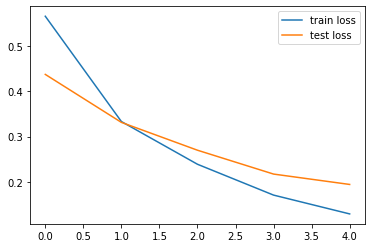

In [139]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend();

Por fim, calculamos a **Accuracy** do nosso modelo:

In [140]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_iter:
    targets = targets.view(-1, 1).float()
    # Forward pass
    outputs = model(inputs)
    # Obtém previsões
    predictions = (outputs > 0)
    # Atualiza os contadores
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_iter:
    targets = targets.view(-1, 1).float()
    # Forward pass
    outputs = model(inputs)
    # Obtém previsões
    predictions = (outputs > 0)
    # Atualiza os contadores
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9744, Test acc: 0.9354
